# Data Challenge 2


Data Challenge:
Company XYZ sells a software for $39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price ($39), while a random sample of 33% users a higher price ($59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users. Especially she asked you the following questions:

1. Should the company sell its software for $39 or $59?

2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

3. The VP of Product feels that the test has been running for too long and she should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days would you have stopped the test? Please, explain why.

Let's load the data and take a look at it:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#load user table:
users = pd.read_csv("user_table.csv")
users.shape

(275616, 5)

In [2]:
#load the test results:
test_results = pd.read_csv("test_results.csv", index_col = 0)
test_results.shape

(316800, 8)

It seems our two tables have different numbers of observations:

In [3]:
len(users['user_id']) - len(test_results['user_id'])

-41184

The users table is missing 41184 users that are in the test_results table. Let's see what info we have in each:

In [4]:
users.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [5]:
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0


Since the relevant information is in the table that has more data (conversion, whether they were test or control), let's just impute some missing data about some 41K users (with 'Unknown' as City so as to not bias the rest of the data). I'll decide down the line when I get to City relevance how to deal with those. Check for duplicates in user_id, and deal with that first, then merge the tables to get one nice dataframe to work with.

In [6]:
len(users['user_id'].unique()) - len(users['user_id'])

0

In [7]:
len(test_results['user_id'].unique()) - len(test_results['user_id'])

0

In [8]:
df = test_results.merge(users, how='left', on='user_id')

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 0 to 316799
Data columns (total 12 columns):
user_id             316800 non-null int64
timestamp           316466 non-null object
source              316488 non-null object
device              316800 non-null object
operative_system    296461 non-null object
test                316800 non-null int64
price               316800 non-null float64
converted           316800 non-null int64
city                275616 non-null object
country             275616 non-null object
lat                 275616 non-null float64
long                275616 non-null float64
dtypes: float64(3), int64(3), object(6)
memory usage: 31.4+ MB


In [10]:
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,Fishers,USA,39.95,-86.02


In [11]:
df.operative_system.unique()

array(['iOS', 'android', 'mac', 'windows', nan, 'i0S', 'wnddows',
       'anroid', 'apple'], dtype=object)

There are some names of OS systems here that are obviously misspelled, so let's correct the names. 

In [12]:
df.device.value_counts()

mobile    186471
web       130329
Name: device, dtype: int64

Most customers use the software on their mobile device 

In [13]:
def rep_val(dataframe):
  if dataframe['device'] == 'web' and dataframe['operative_system'] == 'apple': return 'mac'
  elif dataframe['device'] == 'mobile' and dataframe['operative_system'] == 'apple': return 'iOS'
  elif dataframe['operative_system'] == 'wnddows': return 'windows'
  elif dataframe['operative_system'] == 'i0S': return 'iOS'
  elif dataframe['operative_system'] == 'anroid': return 'android'
  elif pd.isnull(dataframe['operative_system']): return 'Other'
  else: return dataframe['operative_system']

df['operative_system'] = df.apply(rep_val, axis=1)



In [14]:
df.operative_system.unique()

array(['iOS', 'android', 'mac', 'windows', 'Other'], dtype=object)

In [15]:
df.operative_system.value_counts()

windows    100976
iOS         95465
android     74935
mac         25085
Other       20339
Name: operative_system, dtype: int64

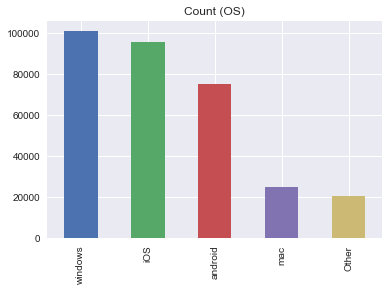

In [16]:
sns.set()
df['operative_system'].value_counts().plot(kind='bar', title='Count (OS)');

It seems that we have OS info for almost 300K users, which means we're missing it for about 20K users. More interestingly, windows is the top OS for the users of this software, but the iOS and android users combined (mobile device users) outnumber the windows and mac users combined. 

In [17]:
df.price.value_counts()

39.0           200747
59.0           112979
536537851.0         1
722005503.0         1
362003840.0         1
361763199.0         1
361601300.0         1
723198958.0         1
361468456.0         1
361357237.0         1
722266243.0         1
361101880.0         1
360980365.0         1
719974521.0         1
721845395.0         1
721543996.0         1
721022978.0         1
720964662.0         1
720460363.0         1
720433591.0         1
720424548.0         1
720402017.0         1
360126610.0         1
724045060.0         1
724296096.0         1
724581334.0         1
725976490.0         1
727515407.0         1
727478543.0         1
727148827.0         1
                ...  
435371271.0         1
870319018.0         1
870277127.0         1
870099143.0         1
435019436.0         1
873318420.0         1
873722285.0         1
877028844.0         1
875685698.0         1
876646250.0         1
876638586.0         1
876622876.0         1
876405411.0         1
876374904.0         1
876209052.

Strangely enough, there are 3074 observations with some ridiculous prices, and it's impossible to infer the correct price from this weird number. Let's take a look at the test versus control column, maybe we can use that to infer the correct prices. 

In [18]:
df.test.value_counts()

0    202727
1    114073
Name: test, dtype: int64

In [19]:
df[['price','test']]

,price,test
0,39.0,0
1,39.0,0
2,39.0,0
3,59.0,1
4,39.0,0
5,39.0,0
6,39.0,0
7,59.0,1
8,59.0,1
9,59.0,1


These seem to be preserved, so one option is to change those ridiculous numbers in price column to 39 if control, and 59 if test.

In [20]:
df['price'] = np.where(df.test == 1, 59.0, 39.0)

In [21]:
df.price.value_counts()

39.0    202727
59.0    114073
Name: price, dtype: int64

In [22]:
df.source.value_counts()

direct_traffic     60307
ads-google         59319
ads_facebook       53337
ads_other          29849
seo-google         23160
ads-bing           22851
seo_facebook       21185
friend_referral    20672
seo-other           9250
ads-yahoo           7573
seo-yahoo           6836
seo-bing            2149
Name: source, dtype: int64

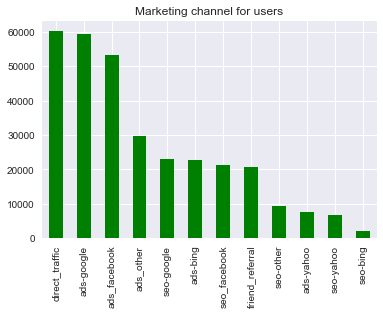

In [23]:
df['source'].value_counts().plot(kind='bar', title='Marketing channel for users', color = ['green']);

In [24]:
df.city.value_counts()

New York                    25748
Chicago                      7153
Houston                      6706
San Antonio                  4633
Los Angeles                  4141
San Jose                     3354
Indianapolis                 3217
Jacksonville                 2905
Philadelphia                 2541
Las Vegas                    2426
Austin                       2292
Seattle                      2204
Oklahoma City                1796
Charlotte                    1768
Tucson                       1732
Virginia Beach               1712
Oakland                      1686
Nashville                    1581
Mesa                         1557
Memphis                      1540
Minneapolis                  1466
Fort Worth                   1429
Buffalo                      1303
Raleigh                      1293
New Orleans                  1263
Springfield                  1246
Tampa                        1217
Dallas                       1207
Detroit                      1178
Plano         

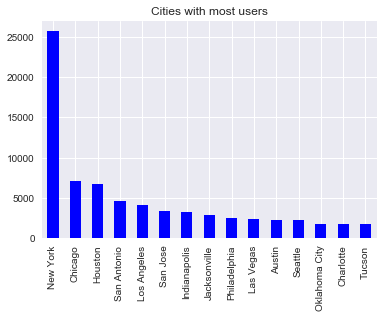

In [25]:
df['city'].value_counts()[:15].plot(kind='bar', title='Cities with most users', color = ['blue']);

New York is by far the main market for this software

###### Now let's take a look at conversion rate and price, and check whether the increased price resulted in a better conversion rate or at least an increase in revenue


In [26]:
test_conv=pd.crosstab(df.test,df.converted)
print(test_conv)

converted       0     1
test                   
0          198692  4035
1          112300  1773


In [27]:
from scipy import stats

#Compute  conversion rates:
print(test_conv[1]/test_conv[0])
term_test = df[df['test']==1]
term_ctrl = df[df['test']==0]
stats.ttest_ind(term_ctrl['converted'], term_test['converted'])


test
0    0.020308
1    0.015788
dtype: float64


Ttest_indResult(statistic=8.78381266742153, pvalue=1.5878799805343215e-18)

The conversion rate for the control group is 2%, while in the test group it is only 1.57%, so the increased price does lower the conversion rate. Let's now check the revenue:

In [28]:
print(np.mean(term_ctrl.converted * 39.0))
print(np.mean(term_test.converted * 59.0))

0.7762409545842438
0.9170180498452745


In spite of a significant drop in conversion rate for the test group (which sees the 59 price tag), the revenue per viewer is still greater when the price is higher: 91.7 cents versus 77.6 cents in the control group (which sees 39).

## Based on this finding, the company should increase the price to 59 for all viewers.

Now let's take a look at conversion rate in time, to see when this test should have given the information needed. For this, I'll need to transform the time info to the pandas datetime format and see how that looks. 

No handles with labels found to put in legend.


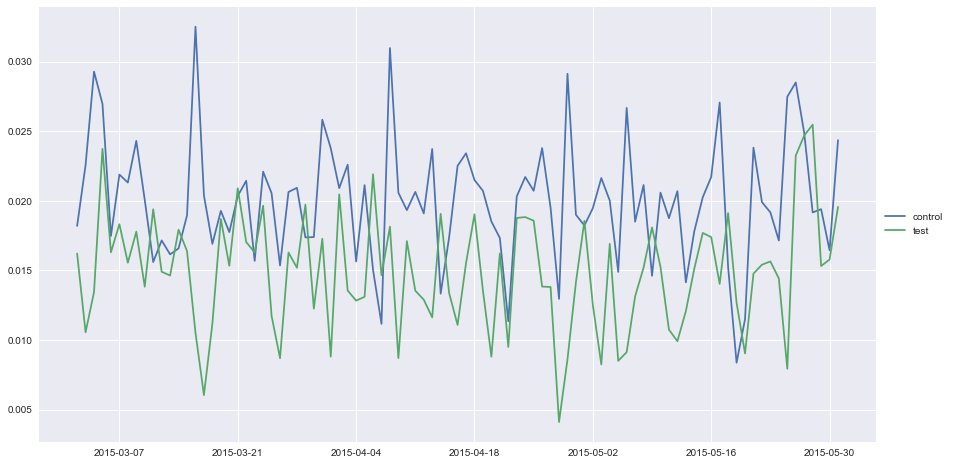

In [29]:
import re
import pylab as p

df['timestamp'] = pd.to_datetime(df['timestamp'], errors = 'coerce')
df['date'] = df['timestamp'].dt.date
dates = df['date']

    
#df['control'] = df['test'].apply(lambda x: 1 if x==0 else 0 )
df1 = df[df['test']== 1][['converted','date']]
grp_mean=df1.groupby('date').mean()
#print(grp_mean)
df2 = df[df['test']== 0][['converted','date']]
grp_mean2=df2.groupby('date').mean()

figure = plt.figure(figsize=(15, 8))
_=p.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_=p.plot(grp_mean2['converted'],'-', label="control")#control

_=p.plot(grp_mean['converted'],'-', label="test")
_=p.legend(loc='center left', bbox_to_anchor=(1, 0.5))#test

It looks like the conversion rate has been consistently higher for control (lower price) than test (higher price).
There are large fluctuations and it's hard to tell whether it is actually increasing (seems so in the last week or so). Perhaps taking a closer look at the cities with high conversion rate will be more informative:

In [30]:
df1 = df[['converted','city']]
grp_mean=df1.groupby('city').mean()
sort_df = grp_mean.sort_values(by='converted', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
sort_df.head(20) 

,converted
city,
North Atlanta,0.200000
Catonsville,0.153846
Saint Charles,0.142857
Parkway-South Sacramento,0.117647
Findlay,0.111111
Blue Springs,0.095238
Bonita Springs,0.090909
Lehigh Acres,0.086957
Parsippany-Troy Hills Township,0.081081


Not sure what to make of this - they seem like small cities that I cannot figure out - is that Hilo, Hawaii? And Montebello, CA? No clue. And i'm running out of time. 